# Module 11 Part 1: Optimizing Deep Neural Networks - Vanishing/Exploding Gradient Problem

# Introduction

At some point, you will need to train a much deeper neural network with many layers, each containing hundreds of neurons, connected by hundreds of thousands of connections. Inevitably, you will face several problems throughout this process:

- The **vanishing gradients problem** or the related **exploding gradient problem** &mdash; these problems make it very hard to train lower layers.


- With such a large network, training will be extremely slow and take up a great deal of computing power.


- A model with millions of parameters will severely risk overfitting the training set and thus reduce the accuracy of the model.

Here we will go through each of these problems and present techniques to solve them.

This module consists of 3 parts:

- **Part 1** - Vanishing/Exploding Gradient Problem

- **Part 2** - Using Faster Optimizers

- **Part 3** - Avoiding Overfitting through Regularization

Each part is provided in a separate notebook file. It is recommended that you follow the order of the notebooks.

# Learning Outcomes

In this module, you will:

* Explore the vanishing gradient problem and some of the most popular solutions to this problem
* Become familiar with various optimizers that can speed up the training of large models tremendously compared to basic gradient descent
* Be introduced to a few popular regularization techniques for large neural networks

# Readings and Resources

We invite you to further supplement this notebook with the following recommended texts/resources.

- Géron, A. (2019). Chapter 11: Training Deep Neural Nets in *Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow* (2nd ed.). O’Reilly Media. https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/


- TensorFlow documentation and tutorials: https://www.tensorflow.org/tutorials


- Kathuria, A. (2018). Paperspace blog: Intro to optimization in deep learning: Vanishing gradients and choosing the right activation function. https://blog.paperspace.com/vanishing-gradients-activation-function/

<h1>Table of Contents<span class="tocSkip"></span></h1>
<br>
<div class="toc">
<ul class="toc-item">
<li><span><a href="#Module-11-Part-1:-Optimizing-Deep-Neural-Networks---Vanishing/Exploding-Gradient-Problem" data-toc-modified-id="Module-11-Part-1:-Optimizing-Deep-Neural-Networks---Vanishing/Exploding-Gradient-Problem">Module 11 Part 1: Optimizing Deep Neural Networks - Vanishing/Exploding Gradient Problem</a></span>
</li>
<li><span><a href="#Introduction" data-toc-modified-id="Introduction">Introduction</a></span>
</li>
<li><span><a href="#Learning-Outcomes" data-toc-modified-id="Learning-Outcomes">Learning Outcomes</a></span>
</li>
<li><span><a href="#Readings-and-Resources" data-toc-modified-id="Readings-and-Resources">Readings and Resources</a></span>
</li>
<li><span><a href="#Table-of-Contents" data-toc-modified-id="Table-of-Contents">Table of Contents</a></span>
</li>
<li><span><a href="#Vanishing/Exploding-Gradient-Problem" data-toc-modified-id="Vanishing/Exploding-Gradient-Problem">Vanishing/Exploding Gradient Problem</a></span>
<ul class="toc-item">
<li><span><a href="#Overview-of-the-problem" data-toc-modified-id="Overview-of-the-problem">Overview of the problem</a></span>
</li>
<li><span><a href="#Xavier-and-He-Initialization" data-toc-modified-id="Xavier-and-He-Initialization">Xavier and He Initialization</a></span>
</li>
<li><span><a href="#Nonsaturating-Activation-Functions" data-toc-modified-id="Nonsaturating-Activation-Functions">Nonsaturating Activation Functions</a></span>
<ul class="toc-item">
<li><span><a href="#Advanced-Activations" data-toc-modified-id="Advanced-Activations">Advanced Activations</a></span>
</li>
<li><span><a href="#Choosing-an-Activation-Function" data-toc-modified-id="Choosing-an-Activation-Function">Choosing an Activation Function</a></span>
</li>
</ul>
</li>
<li><span><a href="#Batch-Normalization" data-toc-modified-id="Batch-Normalization">Batch Normalization</a></span>
</li>
</ul>
</li>
<li><span><a href="#References" data-toc-modified-id="References">References</a></span>
</li>
</ul>
</div>

# Vanishing/Exploding Gradient Problem

We will start by explaining the vanishing gradients problem and exploring some of the most popular solutions to this problem.

## Overview of the problem

As we know from the previous module, the backpropagation algorithm works by going from the output layer to the input layer, propagating the gradients along the way. By the chain rule, the derivatives of each layer are multiplied down the network (from the final layer to the initial) to compute the derivatives of the weight parameters of initial layers. Once the algorithm has computed the gradient of the cost function with regards to each parameter in the network, it uses these gradients to update each parameter with a gradient descent step. 

This is fairly straightforward. However, the gradients often get smaller and smaller as the algorithm progresses down to the lower layers. As a result, the gradient descent update leaves the lower layer connection weights virtually unchanged, and training never converges. This is called the **vanishing gradients problem**. For a shallow network with only a few layers, this isn't a huge problem. However, when more layers are used, it can cause the gradient to be too small for training to work effectively. In some cases, the opposite can happen: the gradients get so big that the algorithm diverges. This is called **exploding gradients**, which mostly occurs in recurrent neural networks (which are not covered in this course).

More generally, distributed neural networks (DNNs) suffer from unstable gradients and different layers may learn at widely different rates.

To dig into this phenomenon, let's quickly explore two very common neural network activation functions: the **sigmoid function** and the **tanh function**. In the plots below, we show the output of both of these functions along with their gradients.

In [1]:
# Basic setup
import numpy as np
import matplotlib.pyplot as plt

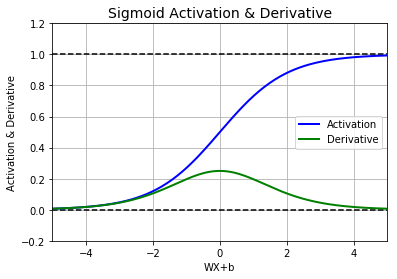

In [2]:
# Plot the sigmoid function
z = np.linspace(-5, 5, 200)

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_gradient(z):
    return sigmoid(z) * (1-sigmoid(z))

plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([-5, 5], [0, 0], 'k--')
plt.plot(z, sigmoid(z), "b-", linewidth=2, label='Activation')
plt.plot(z, sigmoid_gradient(z), "g-", linewidth=2, label='Derivative')
plt.legend()
plt.grid(True)
plt.title("Sigmoid Activation & Derivative", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])
plt.xlabel('WX+b')
plt.ylabel('Activation & Derivative')
plt.show()

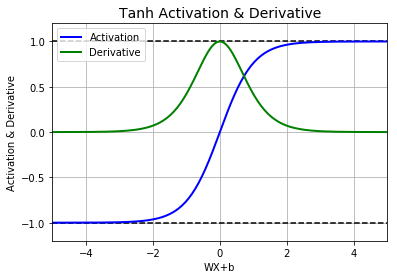

In [3]:
# Plot the tanh function
def tanh(z):
    num = np.exp(z) - np.exp(-z)
    denom = np.exp(z) + np.exp(-z)
    return num/denom

def tanh_gradient(z):
    num = (np.exp(z) - np.exp(-z))**2
    denom = (np.exp(z) + np.exp(-z))**2
    return 1- num/denom

plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot(z, tanh(z), "b-", linewidth=2, label='Activation')
plt.plot(z, tanh_gradient(z), "g-", linewidth=2, label='Derivative')
plt.legend()
plt.grid(True)
plt.title("Tanh Activation & Derivative", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])
plt.xlabel('WX+b')
plt.ylabel('Activation & Derivative')

plt.show()

Looking at the sigmoid activation function, you can see that when inputs become large (negative or positive), the function saturates at 0 or 1 (becomes very close to either value), with a derivative (or gradient) extremely close to 0. The same goes for the tanh function. As the activation outputs get close to either 1 or -1, the value of the function derivative gets closer and closer to zero. This is called **saturation**.

Thus, when backpropagation kicks in, it has virtually no gradient to propagate back through the network, and what little gradient exists keeps getting diluted as backpropagation progresses through the top layers, leaving nothing for the lower layers. This is a huge problem, as initial layers are often crucial to recognizing the core elements of the input data and can lead to overall inaccuracy of the whole network.

To further illustrate this problem, we have developed a simple model that takes in a `layer` parameter, and dynamically updates the graph with the specified number of dense layers. We then extract the value of the weight gradients at the *first layer*. As you will see, when the number of layers gets larger, the value of the gradients at the *first* layer gets smaller and smaller.

To change the activation function for our hidden labels, all we have to do is change the `activation` parameter of the `tf.keras.layers.Dense` function. We will implement a function called `layer1_gradients` to wrap all of the model development into a single line of code so we can rapidly test the effect of multiple activation functions. The arguments of the function will include:

 - **`layers`**: Number of layers in the deep neural network.
 
 
 - **`n_neurons`**: Number of neurons in each hidden layer (defaults to 5).
 
 
 - **`n_inputs`**: Number of input features in the first layer (defaults to 784 for MNIST).
 
 
 - **`n_outputs`**: Number of model outputs (defaults to 10 for MNIST).
 
 
 - **`iterations`**: Number of iterations to run each model, as we will want to extract an average of the gradients (defaults to 10).
 
 
 - **`activate`**: The activation function to use in the hidden layers (defaults to sigmoid). Here we simply pass the name of the function we want to use (a string value), but we can also explicitly pass a `tf.keras.activations` function.
 
 
 - **`init`**: The initialization strategy to use in the hidden layers (defaults to `random_normal`). Here we simply pass the name of the initialization strategy we want to use (a string value), but we can also explicitly pass a `tf.keras.initializers` function.
 
 
 - **`print_`**: Whether or not to print the outputs.

**NOTE:** We have taken the L2 norm of the gradients here (as there will be some negative and positive gradients) and re-executed the code over 10 iterations to get an average.

In [ ]:
from time import time
import tensorflow as tf

# Create the run_model function
tf.logging.set_verbosity(tf.logging.ERROR)

def layer1_gradients(layers, n_neurons=5, n_inputs=784, n_outputs=10, iterations=10, activate='sigmoid', init='random_normal', print_=True):
    tf.reset_default_graph()
    # Inputs (use same data for each iteration)
    X = tf.constant(X_train)
    y = tf.constant(y_train)
    # Build layers
    L = tf.keras.layers.Dense(units=n_neurons, activation=activate, kernel_initializer=init)(X)
    for layer in range(layers-1):
        L = tf.keras.layers.Dense(units=n_neurons, activation=activate, kernel_initializer=init)(L)
    logits = tf.keras.layers.Dense(units=n_outputs, activation='softmax', kernel_initializer=init)(L)
    # Loss 
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
    loss = cce(y, logits)
    # Extract first layer weights and gradients with respect to loss
    first_W = tf.get_default_graph().get_collection('trainable_variables')[0]
    grads_1 = tf.keras.backend.gradients(loss, first_W)
    # Run model!
    init = tf.global_variables_initializer()
    outputs = []
    t0 = time()
    # Run multiple iterations to get average as we are using random initialization
    for i in range(iterations):
        with tf.Session() as sess:
            sess.run(init)
            raw_grad = sess.run(grads_1)
            grads_norm = np.linalg.norm(raw_grad)
            outputs.append(grads_norm)
    t1 = time()
    if print_:
        # Summarize outputs
        string = "{} layers: L2Norm of L1 gradients ({} iterations) = {:.10f}, Runtime = {:.2f} min"
        print(string.format(layers, iterations, np.average(outputs), (t1-t0)/60))
    return np.average(outputs)

You can test out the function below on any dataset, but we will try it with the classic MNIST dataset, which we have loaded and prepped for you below.

In [0]:
# First load in the data
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

def load_mnist_clean(train_size, test_size):
    # Load data
    train, test = tf.keras.datasets.mnist.load_data()        

    # Take sample
    train_idx = np.random.randint(low=0, high=train[0].shape[0], size=train_size)
    test_idx = np.random.randint(low=0, high=test[0].shape[0], size=test_size)
    X_train = train[0][train_idx].reshape(-1,28*28)
    y_train = train[1][train_idx].reshape(-1,1)
    X_test = test[0][test_idx].reshape(-1,28*28)
    y_test = test[1][test_idx].reshape(-1,1)

    # As always, scale the data before running it throught the model
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test) # Use scaler fit on training data

    # Covert to onehot
    oh = OneHotEncoder(categories='auto', sparse=False)
    y_train = oh.fit_transform(y_train)
    y_test = oh.transform(y_test)

    # Check shapes
    print('X_train:',X_train.shape)
    print('y_train:',y_train.shape)
    print('X_test:',X_test.shape)
    print('y_test:',y_test.shape)
    # Check scales
    print('Min:',X_train.min())
    print('Max:',X_train.max())
    # Check data types
    print("X dtype:", X_train.dtype)
    print("y dtype:", y_train.dtype)
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = load_mnist_clean(1000,1000)

X_train: (1000, 784)
y_train: (1000, 10)
X_test: (1000, 784)
y_test: (1000, 10)
Min: -1.2835412806432598
Max: 31.606961258559007
X dtype: float64
y dtype: float64


Let's run it over multiple iterations with an increasing number of iterations, using different activation functions. We will also plot the function outputs (the average L2 norm of layer 1 gradients) of the different models.

Running models with sigmoid activations and random initialization
2 layers: L2Norm of L1 gradients (10 iterations) = 0.0016843699, Runtime = 0.02 min
4 layers: L2Norm of L1 gradients (10 iterations) = 0.0000016756, Runtime = 0.02 min
6 layers: L2Norm of L1 gradients (10 iterations) = 0.0000000011, Runtime = 0.02 min
8 layers: L2Norm of L1 gradients (10 iterations) = 0.0000000000, Runtime = 0.02 min
10 layers: L2Norm of L1 gradients (10 iterations) = 0.0000000000, Runtime = 0.03 min
Running models with tanh activations and random initialization
2 layers: L2Norm of L1 gradients (10 iterations) = 0.0200520237, Runtime = 0.02 min
4 layers: L2Norm of L1 gradients (10 iterations) = 0.0002763347, Runtime = 0.02 min
6 layers: L2Norm of L1 gradients (10 iterations) = 0.0000027835, Runtime = 0.02 min
8 layers: L2Norm of L1 gradients (10 iterations) = 0.0000000271, Runtime = 0.03 min
10 layers: L2Norm of L1 gradients (10 iterations) = 0.0000000004, Runtime = 0.03 min
Running models with ReLU acti

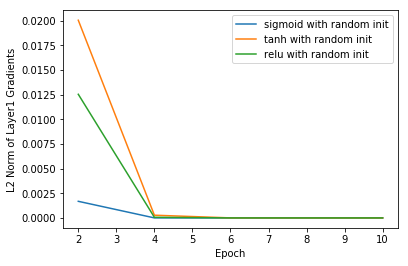

In [0]:
# Run the 5 different models (using sigmoid & tanh), each with a greater number of layers
layers = list(range(2,12,2))

sig_grads = []
tanh_grads = []
relu_grads = []


print("Running models with sigmoid activations and random initialization")
for i in layers:
    sig_grads.append(layer1_gradients(i, activate='sigmoid'))

print("Running models with tanh activations and random initialization")
for i in layers:
    tanh_grads.append(layer1_gradients(i, activate='tanh'))
    
print("Running models with ReLU activations and random initialization")
for i in layers:
    relu_grads.append(layer1_gradients(i, activate='relu'))

plt.plot(layers, sig_grads, label='sigmoid with random init')
plt.plot(layers, tanh_grads, label='tanh with random init')
plt.plot(layers, relu_grads, label='relu with random init')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('L2 Norm of Layer1 Gradients')
plt.show()

As expected, the L2 norm of the gradients decreases significantly as we add more layers to our model. This is the vanishing gradient problem, and there are multiple ways to solve it, many of which we will discuss now.

## Xavier and He Initialization

Significant progress on solving the vanishing gradient problem was made with the 2010 paper "Understanding the Difficulty of Training Deep Feedforward Neural Networks": http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf (Glorot & Bengio, 2010). The authors of the paper narrowed down the problem to two main issues:

1. The popular logistic sigmoid activation function (when it is used as an activation function in hidden layers).<br><br>

2. The random weight initialization technique (using a normal distribution with a mean of 0 and a standard deviation of 1).

In short, they illustrated that these two configurations combined caused the variance of the outputs of each layer to be MUCH greater than the variance of its inputs. In other words, as you go forward through the network, the larger variances saturate the outputs, and the gradients get super small. This is actually made worse by the fact that the logistic function has a mean of 0.5, not 0 like the tanh function (which is why we see slightly better results above with the tanh function!). 

To address this issue, Glorot and Bengio proposed two solutions:

1. The variance of the outputs of each layer should be equal to the variance of its inputs<br><br>

2. The gradients should have equal variance before and after flowing through a layer in reverse direction

It is actually not possible to guarantee both unless the layer has an equal number of input and output connections, but they proposed a good compromise that has proven to work very well in practice: 

- The connection weights must be initialized randomly as described in the equation below, where `n_inputs` and `n_outputs` are the number of input and output connections for the layer whose weights are being initialized.

This is called **Xavier initialization or Glorot initialization**:

- *Normal distribution* with mean of 0 and standard deviation of  $\sigma=\sqrt{\frac{2}{\text{n_inputs + n_outputs}}}$

or

- *Uniform distribution* with between $-r$ and $r$ where $r=\sqrt{\frac{6}{\text{n_inputs + n_outputs}}}$


Using the Xavier initialization strategy can speed up training considerably, and it is one of the tricks that has led to the current success of deep learning. Some recent papers have provided similar strategies for different activation functions, as shown in the table below. The initialization strategy for the ReLU activation function (and its variants, including the ELU activation described shortly) is sometimes called **He initialization** (after the last name of its author).

| **Activation Function** | &nbsp;&nbsp;&nbsp;&nbsp;**Uniform distribution $[-r,r]$**&nbsp;&nbsp;&nbsp;&nbsp; | &nbsp;&nbsp;&nbsp;**Normal distribution**&nbsp;&nbsp;&nbsp; | 
| ------- | ------- | ------- |
| sigmoid | $r=\sqrt{\frac{6}{\text{n_inputs + n_outputs}}}$ | $\sigma=\sqrt{\frac{2}{\text{n_inputs + n_outputs}}}$ |
| tanh | $r=4\sqrt{\frac{6}{\text{n_inputs + n_outputs}}}$ | $\sigma=4\sqrt{\frac{2}{\text{n_inputs + n_outputs}}}$ |
| ReLU (he_init) | $r=\sqrt{2}\sqrt{\frac{6}{\text{n_inputs + n_outputs}}}$ | $\sigma=\sqrt{2}\sqrt{\frac{2}{\text{n_inputs + n_outputs}}}$ |

In our `layer1_gradients` models above, we used the `random_normal` initialization. Below we will re-run these models using Glorot (Xavier) initialization (uniformly distributed). 

To do so, all we have to do is replace the `random_normal` string with our desired activation function. As noted above, we can also directly call the Keras Glorot initializer function with the `tf.keras.initializers.glorot_normal` class and pass it into our function.

Running models with sigmoid activations and glorot initialization
2 layers: L2Norm of L1 gradients (10 iterations) = 0.1065135752, Runtime = 0.02 min
4 layers: L2Norm of L1 gradients (10 iterations) = 0.0056932152, Runtime = 0.02 min
6 layers: L2Norm of L1 gradients (10 iterations) = 0.0002770446, Runtime = 0.02 min
8 layers: L2Norm of L1 gradients (10 iterations) = 0.0000187530, Runtime = 0.03 min
10 layers: L2Norm of L1 gradients (10 iterations) = 0.0000007224, Runtime = 0.03 min
Running models with tanh activations and glorot initialization
2 layers: L2Norm of L1 gradients (10 iterations) = 1.1149827830, Runtime = 0.02 min
4 layers: L2Norm of L1 gradients (10 iterations) = 0.7459900304, Runtime = 0.02 min
6 layers: L2Norm of L1 gradients (10 iterations) = 0.5390352670, Runtime = 0.03 min
8 layers: L2Norm of L1 gradients (10 iterations) = 0.4773369563, Runtime = 0.03 min
10 layers: L2Norm of L1 gradients (10 iterations) = 0.2956322305, Runtime = 0.03 min
Running models with ReLU acti

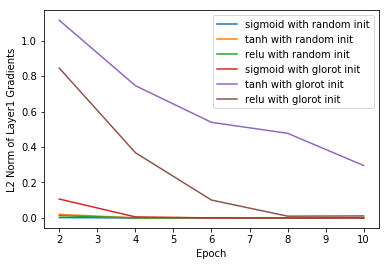

In [0]:
# Run the 5 different models (using sigmoid & tanh), each with a greater number of layers
layers = list(range(2,12,2))
init = tf.keras.initializers.glorot_uniform

sig_grads_glor = []
tanh_grads_glor = []
relu_grads_glor = []

print("Running models with sigmoid activations and glorot initialization")
for i in layers:
    sig_grads_glor.append(layer1_gradients(i, activate='sigmoid', init=init))

print("Running models with tanh activations and glorot initialization")
for i in layers:
    tanh_grads_glor.append(layer1_gradients(i, activate='tanh', init=init))
    
print("Running models with ReLU activations and glorot initialization")
for i in layers:
    relu_grads_glor.append(layer1_gradients(i, activate='relu', init=init))
    

plt.plot(layers, sig_grads, label='sigmoid with random init')
plt.plot(layers, tanh_grads, label='tanh with random init')
plt.plot(layers, relu_grads, label='relu with random init')
plt.plot(layers, sig_grads_glor, label='sigmoid with glorot init')
plt.plot(layers, tanh_grads_glor, label='tanh with glorot init')
plt.plot(layers, relu_grads_glor, label='relu with glorot init')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('L2 Norm of Layer1 Gradients')
plt.show()

As we can see, the layer 1 gradients suffer from saturation to a much lesser degree when Glorot initialization is applied. Again, this affect will change based on the data and activation function you choose, but in general Glorot is the best place to start (or He initialization if you are using ReLU or ReLU relatives).

In addition, we want to stress that the reason this issue is so important is that vanishing gradients can exponentially slow down training or prevent convergence all together.

Below we will train a bunch of models using different initialization strategies and observe how the accuracy changes on each iteration (using ReLU as our base activation function). 

To do this, we create a wrapper function that creates a simple feedforward network with 5 layers. We will include `activation` and `initializer` parameters so we can test multiple models. Below we also load a larger MNIST sample to make the training more interesting.

In [0]:
from tensorflow.keras import layers

# Initialize simple_model function
def simple_model(initializer, activation='relu'): # Use relu as base activation function
    return tf.keras.Sequential([layers.Dense(32, activation, input_shape=(784,), kernel_initializer=initializer),
                                layers.Dense(32, activation, kernel_initializer=initializer),
                                layers.Dense(32, activation, kernel_initializer=initializer),
                                layers.Dense(32, activation, kernel_initializer=initializer),
                                layers.Dense(10, activation='softmax', kernel_initializer=tf.keras.initializers.glorot_normal())])

In [0]:
# First load in larger dataset
X_train, X_test, y_train, y_test = load_mnist_clean(60000,10000) # take full dataset

X_train: (60000, 784)
y_train: (60000, 10)
X_test: (10000, 784)
y_test: (10000, 10)
Min: -1.2730298647380967
Max: 244.94693302850283
X dtype: float64
y dtype: float64


**Zeros initialization** 

In [0]:
# Set params
init = tf.initializers.zeros()
activate = 'relu'

# Run model
optimizer = tf.keras.optimizers.SGD(0.01)
model_ze = simple_model(init, activate)
model_ze.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model_ze.fit(X_train, y_train, epochs=10, batch_size=3200, validation_data=(X_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 1s 14us/sample - loss: 2.3026 - acc: 0.1114 - val_loss: 2.3025 - val_acc: 0.1102
Epoch 2/10
60000/60000 [==============================] - 1s 11us/sample - loss: 2.3025 - acc: 0.1120 - val_loss: 2.3025 - val_acc: 0.1102
Epoch 3/10
60000/60000 [==============================] - 1s 11us/sample - loss: 2.3025 - acc: 0.1120 - val_loss: 2.3024 - val_acc: 0.1102
Epoch 4/10
60000/60000 [==============================] - 1s 11us/sample - loss: 2.3024 - acc: 0.1120 - val_loss: 2.3024 - val_acc: 0.1102
Epoch 5/10
60000/60000 [==============================] - 1s 11us/sample - loss: 2.3024 - acc: 0.1120 - val_loss: 2.3024 - val_acc: 0.1102
Epoch 6/10
60000/60000 [==============================] - 1s 11us/sample - loss: 2.3023 - acc: 0.1120 - val_loss: 2.3023 - val_acc: 0.1102
Epoch 7/10
60000/60000 [==============================] - 1s 11us/sample - loss: 2.3023 - acc: 0.1120 - val_loss: 2.

**Random Normal Initialization**

In [0]:
# Set params
init = tf.initializers.random_normal()
activate = 'relu'

# Run model
optimizer = tf.keras.optimizers.SGD(0.01)
model_rn = simple_model(init, activate)
model_rn.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model_rn.fit(X_train, y_train, epochs=10, batch_size=3200, validation_data=(X_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 1s 13us/sample - loss: 980.3213 - acc: 0.1266 - val_loss: 6.1785 - val_acc: 0.1202
Epoch 2/10
60000/60000 [==============================] - 1s 11us/sample - loss: 4.3937 - acc: 0.1211 - val_loss: 4.0267 - val_acc: 0.1252
Epoch 3/10
60000/60000 [==============================] - 1s 11us/sample - loss: 3.2194 - acc: 0.1228 - val_loss: 3.4587 - val_acc: 0.1229
Epoch 4/10
60000/60000 [==============================] - 1s 11us/sample - loss: 2.8541 - acc: 0.1217 - val_loss: 3.1750 - val_acc: 0.1117
Epoch 5/10
60000/60000 [==============================] - 1s 12us/sample - loss: 2.6760 - acc: 0.1205 - val_loss: 3.0280 - val_acc: 0.1209
Epoch 6/10
60000/60000 [==============================] - 1s 11us/sample - loss: 2.5739 - acc: 0.1170 - val_loss: 2.9284 - val_acc: 0.1211
Epoch 7/10
60000/60000 [==============================] - 1s 11us/sample - loss: 2.5115 - acc: 0.1181 - val_loss: 

**Glorot Normal Initialization (Xavier Initialization)**

In [0]:
# Set params
init = tf.keras.initializers.glorot_uniform()
activate = 'relu'

# Run model
optimizer = tf.keras.optimizers.SGD(0.01)
model_xa = simple_model(init, activate)
model_xa.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model_xa.fit(X_train, y_train, epochs=10, batch_size=3200, validation_data=(X_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 1s 13us/sample - loss: 2.3295 - acc: 0.1097 - val_loss: 2.3101 - val_acc: 0.1311
Epoch 2/10
60000/60000 [==============================] - 1s 11us/sample - loss: 2.2984 - acc: 0.1352 - val_loss: 2.2831 - val_acc: 0.1569
Epoch 3/10
60000/60000 [==============================] - 1s 11us/sample - loss: 2.2714 - acc: 0.1686 - val_loss: 2.2579 - val_acc: 0.2042
Epoch 4/10
60000/60000 [==============================] - 1s 11us/sample - loss: 2.2450 - acc: 0.2157 - val_loss: 2.2320 - val_acc: 0.2564
Epoch 5/10
60000/60000 [==============================] - 1s 11us/sample - loss: 2.2169 - acc: 0.2637 - val_loss: 2.2032 - val_acc: 0.2954
Epoch 6/10
60000/60000 [==============================] - 1s 11us/sample - loss: 2.1855 - acc: 0.3068 - val_loss: 2.1704 - val_acc: 0.3309
Epoch 7/10
60000/60000 [==============================] - 1s 11us/sample - loss: 2.1497 - acc: 0.3402 - val_loss: 2.

**He Initialization**

In [0]:
# Set params
init = tf.keras.initializers.he_uniform()
activate = 'relu'

# Run model
optimizer = tf.keras.optimizers.SGD(0.01)
model_he = simple_model(init, activate)
model_he.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model_he.fit(X_train, y_train, epochs=10, batch_size=3200, validation_data=(X_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 1s 13us/sample - loss: 2.6259 - acc: 0.1666 - val_loss: 2.2384 - val_acc: 0.2611
Epoch 2/10
60000/60000 [==============================] - 1s 11us/sample - loss: 2.1061 - acc: 0.3140 - val_loss: 1.9705 - val_acc: 0.3720
Epoch 3/10
60000/60000 [==============================] - 1s 11us/sample - loss: 1.8716 - acc: 0.4010 - val_loss: 1.7670 - val_acc: 0.4352
Epoch 4/10
60000/60000 [==============================] - 1s 11us/sample - loss: 1.6853 - acc: 0.4615 - val_loss: 1.6020 - val_acc: 0.4886
Epoch 5/10
60000/60000 [==============================] - 1s 11us/sample - loss: 1.5339 - acc: 0.5092 - val_loss: 1.4652 - val_acc: 0.5327
Epoch 6/10
60000/60000 [==============================] - 1s 11us/sample - loss: 1.4051 - acc: 0.5510 - val_loss: 1.3450 - val_acc: 0.5740
Epoch 7/10
60000/60000 [==============================] - 1s 11us/sample - loss: 1.2913 - acc: 0.5921 - val_loss: 1.

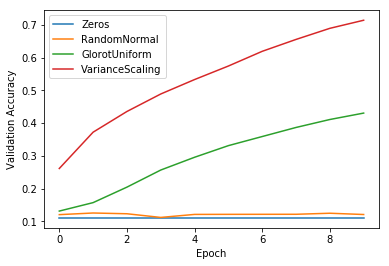

In [0]:
for model in [model_ze, model_rn, model_xa, model_he]:
    plt.plot(model.history.history['val_acc'], label=model.get_config()['layers'][0]['config']['kernel_initializer']['class_name'])

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.show()

**NOTE:** `VarianceScaling` is another name for He initialization.

Our model accuracy after 10 epochs actually goes up significantly from epoch to epoch when we use the "Glorot uniform" and "He uniform" initializations. This makes sense, as the gradient updates are more effectively transferred through to the initial layers, thus speeding up training. `VarianceScaling` (He initialization) is optimized specifically for ReLU activation functions, which explains why it performs the best here.

You are encouraged to experiment with different activation functions and initialization strategies to see if you can improve training accuracy even more.

You may even want to train for more epochs and see how that affects the model.

## Nonsaturating Activation Functions

Proper initialization strategies are incredibly important when addressing the vanishing gradient problem, but we can do more! The next technique involves tweaking the activation functions themselves.

As mentioned above, one of the insights in the 2010 paper by Xavier and Glorot was that the vanishing/exploding gradients problems was in part due a poor choice of activation function, namely the sigmoid activation function. As we demonstrated above, the ReLU or tanh activation functions present excellent alternatives to the sigmoid function. Of particular interest is the ReLU activation function, mostly because it does not saturate for positive values, and also because it is super fast to compute.

However, ReLU activation is not perfect, as it suffers from what is called the **dying ReLU problem**: during training some neurons effectively die, meaning they stop outputting anything other than 0. This is because the gradient of the ReLU function is 0 when its input is negative. In some cases, you may find that half of your network's neurons are dead, especially if you used a large learning rate. 

### Advanced Activations

**Leaky ReLU:**

To solve the dying neuron problem outlined above, researchers came up with a clever variant of the ReLU function called the **leaky ReLU function**. 

Leaky ReLU is defined as $\alpha(z) = max(\alpha z, z)$:

- Hyperparameter $\alpha$ defines how much the function "leaks": it is the slope of the function where $z$ is less than 0 and is typically set to 0.01, though larger leaks (e.g. $\alpha$ = 0.2) can sometimes lead to even better results.


- The small slope ensures that leaky ReLU neurons never die. They can go into a long coma, but they have a chance to eventually wake up (as the activation output will likely never become exactly zero, though it may be very small).

Recent papers have showed that leaky ReLUs often outperform strict ReLU functions. The **randomized leaky ReLU (RReLU)**, where $\alpha$ is picked randomly in a given range during training (and is fixed to an average value during testing), as well as the **parametric leaky ReLU (PReLU)**, where $\alpha$ is authorized to be learned during training, have also both been shown to produce strong results. The RReLU in particular seems to act as a regularizer (reducing the risk of overfitting the training set), while the parametric leaky ReLU (PReLU) tends to outperform ReLU on large image datasets, but on smaller datasets it runs the risk of overfitting the training set.

Below we we have plotted the activation output and derivative of a basic leaky ReLU implementation.

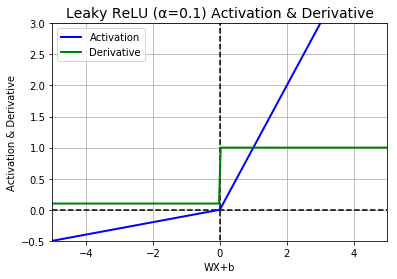

In [0]:
# Plot the sigmoid function
z = np.linspace(-5, 5, 200)

# high alpha for visualization purposes
def leaky_relu(z, alpha=0.1):
    return np.where(z < 0, alpha*z,z)

def leaky_relu_gradient(z, alpha=0.1):
    return np.where(z < 0, alpha,1)


plt.plot([0, 0], [-5, 5], 'k--')
plt.plot([-5, 5], [0, 0], 'k--')
plt.plot(z, leaky_relu(z), "b-", linewidth=2, label='Activation')
plt.plot(z, leaky_relu_gradient(z), "g-", linewidth=2, label='Derivative')
plt.legend()
plt.grid(True)
plt.title("Leaky ReLU (α=0.1) Activation & Derivative", fontsize=14)
plt.axis([-5,5, -0.5, 3])
plt.xlabel('WX+b')
plt.ylabel('Activation & Derivative')
plt.show()

**Exponential Linear Unit (ELU):**

Soon after ReLU was proposed, a 2015 paper by Djork-Arné Clevert et al. proposed a new activation function called the **exponential linear unit (ELU)** that outperformed all the ReLU variants in their experiments (training time was reduced and the neural network performed better on the test set). It is shown below.

$$f(x) = \left \{	\begin{array}{rcl}	\alpha (exp(x) - 1) & \mbox{for} & x \le 0\\	x & \mbox{for} & x > 0\end{array} \right.$$

We have plotted the function as well as its derivative below.

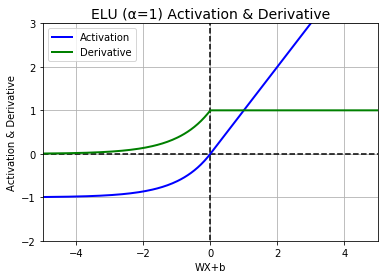

In [0]:
# Plot the sigmoid function
z = np.linspace(-5, 5, 200)

# high alpha for visualization purposes
def elu(z, alpha=1):
    return np.where(z < 0, alpha*np.exp(z)-1,z)

def elu_gradient(z, alpha=1):
    return np.where(z < 0, alpha*np.exp(z),1)

plt.plot([0, 0], [-5, 5], 'k--')
plt.plot([-5, 5], [0, 0], 'k--')
plt.plot(z, elu(z), "b-", linewidth=2, label='Activation')
plt.plot(z, elu_gradient(z), "g-", linewidth=2, label='Derivative')
plt.legend()
plt.grid(True)
plt.title("ELU (α=1) Activation & Derivative", fontsize=14)
plt.axis([-5,5, -2, 3])
plt.xlabel('WX+b')
plt.ylabel('Activation & Derivative')
plt.show()

### Choosing an Activation Function

So, which activation functions should you use for the **hidden layers** of your deep neural network?

The short answer is it will usually vary from dataset to dataset and the type of architecture you choose. However, this trend generally holds:

- $\text{ELU} > \text{Leaky ReLU} > \text{ReLU} > \text{tanh} > \text{sigmoid}$


- If you don’t want to tweak yet another hyperparameter, you may just use the default $\alpha$ values suggested earlier (0.01 for Leaky ReLU, and 1 for ELU).

**Exercise 1**

Let's try and put the `elu` function to the test and see how it compares to our results above. Start with He initialization, but feel free to try out other combinations to get the best accuracy within 10 epochs. Leverage the existing `simple_model` function to perform your tests. You can also try out the `layer1_gradients` function using the `elu` activation function to see how it affects L1 gradients *(make sure to load a smaller dataset with this function, as it will take too long with the full MNSIT dataset).*

In [0]:
# Your work here

In [0]:
# Your work here

In [0]:
# Your work here

**Exercise 1 Solution**

In [0]:
# Set params
activate = 'elu'
init = tf.keras.initializers.he_uniform()

# Run model
optimizer = tf.keras.optimizers.SGD(0.01)
model_he_elu = simple_model(init, activate)
model_he_elu.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model_he_elu.fit(X_train, y_train, epochs=10, batch_size=3200, validation_data=(X_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 1s 15us/sample - loss: 2.4182 - acc: 0.2516 - val_loss: 1.8265 - val_acc: 0.4173
Epoch 2/10
60000/60000 [==============================] - 1s 12us/sample - loss: 1.6384 - acc: 0.4859 - val_loss: 1.4182 - val_acc: 0.5551
Epoch 3/10
60000/60000 [==============================] - 1s 12us/sample - loss: 1.3323 - acc: 0.5844 - val_loss: 1.1937 - val_acc: 0.6279
Epoch 4/10
60000/60000 [==============================] - 1s 12us/sample - loss: 1.1463 - acc: 0.6458 - val_loss: 1.0409 - val_acc: 0.6872
Epoch 5/10
60000/60000 [==============================] - 1s 12us/sample - loss: 1.0141 - acc: 0.6936 - val_loss: 0.9266 - val_acc: 0.7367
Epoch 6/10
60000/60000 [==============================] - 1s 12us/sample - loss: 0.9130 - acc: 0.7330 - val_loss: 0.8374 - val_acc: 0.7669
Epoch 7/10
60000/60000 [==============================] - 1s 12us/sample - loss: 0.8328 - acc: 0.7618 - val_loss: 0.

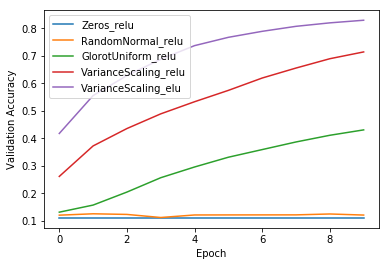

In [0]:
for model in [model_ze, model_rn, model_xa, model_he, model_he_elu]:
    init = model.get_config()['layers'][0]['config']['kernel_initializer']['class_name']
    act = model.get_config()['layers'][0]['config']['activation']
    plt.plot(model.history.history['val_acc'], label = init+"_"+act)

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.show()

It looks like when using He initialization (`VarianceScaling`) the `elu` activation function produces better results!

Again, **the combination will always vary based on the dataset you are running your model on**, so there is no hard and fast rule for choosing the right initialization and activation parameters. The only option is to experiment!

## Batch Normalization

While using He initialization along with ELU can reduce vanishing/exploding gradient issues at the beginning of training, it doesn't guarantee that these won't come back at a later point in the training process. This is largely because as the training process progresses from epoch to epoch, the distribution of each layer's inputs can change significantly as the parameters of the previous layers change. This is called the **internal covariate shift problem**. To address this issue, researches came up with a technique called **batch normalization**.

Batch normalization layers are added in the model just before the activation function of each layer. The operation consists of two main steps:

1. **Zero-centering the inputs:** In order to zero-center and normalize the inputs the algorithm needs to estimate the mean and standard deviation of the inputs. It does so by evaluating the mean and standard deviation of the inputs over the current mini-batch (hence the name “batch normalization”).<br><br>
 
2. **Scaling and shifting:** The zero-centered inputs are then scaled and shifted using two new learnable parameters per layer (one for scaling and one for shifting). In other words, batch normalization lets the model learn the optimal scale and mean of the inputs for each layer. 

Mathematically, these steps can be broken down as follows:

1. **Calculate Mean**: $\mu_B=\frac{1}{m_B} \sum\limits_{i=1}^{m_B}X^i$<br><br>

2. **Calculate StDev**: $\sigma_B^2=\frac{1}{m_B} \sum\limits_{i=1}^{m_B}(X^i-\mu_B)^2$<br><br>

3. **Zero Centre**: $X^i=\frac{X^i-\mu_B}{\sqrt{\sigma_B^2 + \epsilon}}$<br><br>

4. **Scale & Shift**: $Z^i=\gamma X^i + \beta$


where:
- $\mu_B$ is the empirical mean, evaluated over the entire mini-batch.
- $\sigma_B$ is the empirical standard deviation, also evaluated over the entire mini-batch.
- $m_B$ is the number of instances in the mini-batch.
- $X^i$ is the zero-centred and normalized input.
- $\gamma$ is the trainable scaling parameter for the layer.
- $\beta$ is the trainable shifting parameter (offset) for the layer.
- $\epsilon$ is a tiny number to avoid division by zero (typically $10^{-3}$). This is called a *smoothing term.*
- $Z^i$ is the output of the batch normalization operation: a scaled and shifted version of the inputs.

If this process looks familiar, that is because we are simply performing a standard scaling operation that we typically perform on our input data (plus the scaling and shifting component). Essentially we are taking the standard scaling methods we would normally apply to our raw data, and applying it to the inputs at each layer.

To add batch normalization to our model, all we have to do is add a `tensorflow.keras.layers.BatchNormalization` layer in between our dense layers. Here is the "init signature" for the Keras batch normalization layer:

    layers.BatchNormalization(
        ['axis=-1', 'momentum=0.99', 'epsilon=0.001', 'center=True', 'scale=True', "beta_initializer='zeros'", "gamma_initializer='ones'", 
        "moving_mean_initializer='zeros'", "moving_variance_initializer='ones'", 'beta_regularizer=None', 'gamma_regularizer=None', 
        'beta_constraint=None', 'gamma_constraint=None', 'renorm=False', 'renorm_clipping=None', 'renorm_momentum=0.99', 'fused=None', 
        'trainable=True', 'virtual_batch_size=None', 'adjustment=None', 'name=None', '**kwargs'],)

The default batch normalization arguments work for most cases &mdash; however, you are encouraged to dig into the documentation for more clarity. For our purposes, it is most important to note that that each batch layer creates 4 new parameters per layer:

- Two trainable parameters:
    - γ (scale) turned on via the `scale` argument
    - β (offset) turned on via the `center` argument
- And two non-trainable parameters:
    - μ (mean)
    - σ (standard deviation)

Note that we want to perform batch normalization before the activation function at each layer in order to avoid the vanishing gradient problem. To do so, we have to set the `Dense` layer activation parameter to `None` (which is actually the default parameter), and then explicitly add a `tf.layers.Activation` function after our `BatchNormalization` layer. We implement this structure below.

In [0]:
# Initialize simple_model function
def simple_model_bn(initializer='he_normal', activation='relu'): # Use relu as base activation function
    return tf.keras.Sequential([layers.Dense(32, activation=None, input_shape=(784,), kernel_initializer=initializer),
                                layers.BatchNormalization(trainable=True, scale=True, center=True), # Add BatchNorm
                                layers.Activation(activation), # Add relu activation layer
                                layers.Dense(32, activation=None, kernel_initializer=initializer),
                                layers.BatchNormalization(trainable=True, scale=True, center=True), # Add BatchNorm                
                                layers.Activation(activation), # Add relu activation layer
                                layers.Dense(32, activation=None, kernel_initializer=initializer),
                                layers.BatchNormalization(trainable=True, scale=True, center=True), # Add BatchNorm
                                layers.Activation(activation), # Add relu activation layer
                                layers.Dense(32, activation=None, kernel_initializer=initializer),
                                layers.BatchNormalization(trainable=True, scale=True, center=True), # Add BatchNorm
                                layers.Activation(activation), # Add relu activation layer
                                layers.Dense(10, activation='softmax', kernel_initializer=tf.keras.initializers.glorot_normal())])
print("Model WITH BatchNorm")
simple_model_bn().summary()

Model WITH BatchNorm
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 32)                25120     
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
activation (Activation)      (None, 32)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 32)                1056      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
activation_1 (Activation)    (None, 32)                0         
_________________________________________________________________
dense_38 (Dense)             (Non

As we see above, we have 128 parameters per batch normalization layer (32 neurons $\cdot$ 4), and only half of those are trainable (hence the 256 non-trainable parameters). It is important to note that the parameters are treated slightly different during training and testing.

- **Batch normalization during training**: The training data mean and standard deviation values for each mini-batch are typically calculated efficiently during training using a moving average (this is what the `momentum`, `moving_mean_initializer`, and `moving_variance_initializer` parameters in the `tf.keras.layers.BatchNormalization` function are used for).


- **Batch normalization during testing:** There is no mini batch to compute the empirical mean and standard deviation during testing, so instead you simply use the whole training set's mean and standard deviation. That makes sense, as you want to scale and shift the testing data the exact same way you scale and shift the training data.

Batch normalization has been demonstrated to considerably improve the training performance of deep neural networks. Some of the highlights from the research using various model architectures include:

- The vanishing gradients problem is strongly reduced, to the point that even saturating activation functions such as the tanh and even the sigmoid activation function could be used in hidden layers


- Models become much less sensitive to the weight initialization


- Larger learning rates can be used, which can significantly speed up the training process


- Batch normalization also acts like a regularizer, reducing the need for other regularization techniques (such as dropout)

As we can see from the above implementation, batch normalization can certainly add some complexity to the model, but it also **removes the need for normalizing the input data** since the first hidden layer will take care of that provided it is batch normalized. Moreover, there is a runtime penalty: the neural network makes slower predictions due to the extra computations required at each layer. So, if you need predictions to be lightning-fast, you may want to check how well plain ELU + He initialization performs before playing with batch normalization.

Now, let's try to implement batch normalization using a heavily saturating activation function (the sigmoid function, for example), and see how it affects our model accuracy.

In [0]:
# Set params
init = tf.keras.initializers.random_normal()
activate = 'relu'

# Run model
optimizer = tf.keras.optimizers.SGD(0.01)
model_rn = simple_model_bn(init, activate)
model_rn.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model_rn.fit(X_train, y_train, epochs=10, batch_size=3200, validation_data=(X_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 1s 24us/sample - loss: 2.2933 - acc: 0.1465 - val_loss: 2.2984 - val_acc: 0.2064
Epoch 2/10
60000/60000 [==============================] - 1s 14us/sample - loss: 1.8694 - acc: 0.3808 - val_loss: 2.2926 - val_acc: 0.2043
Epoch 3/10
60000/60000 [==============================] - 1s 15us/sample - loss: 1.5731 - acc: 0.5514 - val_loss: 2.2834 - val_acc: 0.2230
Epoch 4/10
60000/60000 [==============================] - 1s 14us/sample - loss: 1.3540 - acc: 0.6276 - val_loss: 2.2698 - val_acc: 0.2748
Epoch 5/10
60000/60000 [==============================] - 1s 14us/sample - loss: 1.1969 - acc: 0.6759 - val_loss: 2.2510 - val_acc: 0.3353
Epoch 6/10
60000/60000 [==============================] - 1s 15us/sample - loss: 1.0764 - acc: 0.7165 - val_loss: 2.2253 - val_acc: 0.4310
Epoch 7/10
60000/60000 [==============================] - 1s 15us/sample - loss: 0.9796 - acc: 0.7499 - val_loss: 2.

Interesting! Using `random_normal` initialization and `relu`, we typically only get up to around ~20% accuracy after 10 epochs. However, with our new batch normalization model, we hit ~81%, which is pretty good considering we are using a simple initialization function. 

**Exercise 2**

Try playing with the model above, using different activation as well as initialization functions and see how high you can get the 10 epoch accuracy. You could even try opening up the `simple_model_bn` function and tweaking some of the `BatchNormalization` parameters if you like (though the defaults should be fine for this relatively simple model). 

In [0]:
# Your work here

In [0]:
# Your work here

In [0]:
# Your work here

**Exercise 2 Solution**

In [0]:
# Set params
init = tf.keras.initializers.he_normal()
activate = 'relu'

# Run model
optimizer = tf.keras.optimizers.SGD(0.01)
model_rn = simple_model_bn(init, activate)
model_rn.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model_rn.fit(X_train, y_train, epochs=10, batch_size=3200, validation_data=(X_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 3s 50us/sample - loss: 2.4650 - acc: 0.1286 - val_loss: 2.4624 - val_acc: 0.1760
Epoch 2/10
60000/60000 [==============================] - 1s 16us/sample - loss: 2.1846 - acc: 0.2370 - val_loss: 2.2383 - val_acc: 0.2411
Epoch 3/10
60000/60000 [==============================] - 1s 13us/sample - loss: 2.0082 - acc: 0.3154 - val_loss: 2.0699 - val_acc: 0.3198
Epoch 4/10
60000/60000 [==============================] - 1s 13us/sample - loss: 1.8768 - acc: 0.3825 - val_loss: 1.9282 - val_acc: 0.3982
Epoch 5/10
60000/60000 [==============================] - 1s 16us/sample - loss: 1.7713 - acc: 0.4405 - val_loss: 1.8072 - val_acc: 0.4579
Epoch 6/10
60000/60000 [==============================] - 1s 14us/sample - loss: 1.6819 - acc: 0.4881 - val_loss: 1.7033 - val_acc: 0.5075
Epoch 7/10
60000/60000 [==============================] - 1s 18us/sample - loss: 1.6036 - acc: 0.5264 - val_loss: 1.

In [0]:
# Set params
init = tf.keras.initializers.he_uniform()
activate = 'relu'

# Run model
optimizer = tf.keras.optimizers.SGD(0.01)
model_rn = simple_model_bn(init, activate)
model_rn.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model_rn.fit(X_train, y_train, epochs=10, batch_size=3200, validation_data=(X_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 3s 51us/sample - loss: 2.5580 - acc: 0.1078 - val_loss: 2.4084 - val_acc: 0.1344
Epoch 2/10
60000/60000 [==============================] - 1s 13us/sample - loss: 2.2661 - acc: 0.2022 - val_loss: 2.1996 - val_acc: 0.1992
Epoch 3/10
60000/60000 [==============================] - 1s 13us/sample - loss: 2.0804 - acc: 0.2709 - val_loss: 2.0466 - val_acc: 0.2727
Epoch 4/10
60000/60000 [==============================] - 1s 17us/sample - loss: 1.9566 - acc: 0.3256 - val_loss: 1.9252 - val_acc: 0.3417
Epoch 5/10
60000/60000 [==============================] - 1s 14us/sample - loss: 1.8582 - acc: 0.3751 - val_loss: 1.8249 - val_acc: 0.3946
Epoch 6/10
60000/60000 [==============================] - 1s 17us/sample - loss: 1.7749 - acc: 0.4196 - val_loss: 1.7384 - val_acc: 0.4438
Epoch 7/10
60000/60000 [==============================] - 1s 14us/sample - loss: 1.6987 - acc: 0.4615 - val_loss: 1.

**End of Part 1**

This notebook makes up one part of this module. Now that you have completed this part, please proceed to the next notebook in this module.

If you have any questions, please reach out to your peers using the discussion boards. If you and your peers are unable to come to a suitable conclusion, do not hesitate to reach out to your instructor on the designated discussion board.

# References

- Clevert, D., Unterthiner, T., & Hochreiter, S. (2015). *Fast and Accurate Deep Network Learning by Exponential Linear Unites (ELUs)*. Cornell University. Published as a conference paper at ICLR 2016.


- Glorot, X., & Bengio, Y. (2010). Understanding the difficulty of training deep feedforward neural networks in *Volume 9: Proceedings of the Thirteenth International Conference on Artificial Intelligence and Statistics, 13-15 May 2010, Chia Laguna Resort, Sardinia, Italy* http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf


- PMLR. (2010). *Volume 9: Proceedings of the Thirteenth International Conference on Artificial Intelligence and Statistics, 13-15 May 2010, Chia Laguna Resort, Sardinia, Italy.* http://proceedings.mlr.press/v9/